# Custom CNN

### General Imports

In [1]:
import numpy as np
import pandas as pd
import cv2

import PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import seaborn as sns

### Load Dataset

In [2]:
# use os and cv2 libraries to load and resize the images

labels = ['PNEUMONIA', 'NORMAL']
img_size = 224
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [3]:
#modify accordingly

train_dir = 'archive/chest_xray/train'
test_dir = 'archive/chest_xray/test'
val_dir = 'archive/chest_xray/val'

In [4]:
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

C:\Users\Keshav Ganesh\AppData\Local\Temp\ipykernel_18048\1344827095.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [5]:
train.shape, test.shape, val.shape

((5216, 2), (624, 2), (16, 2))

### Data Visualisation

Text(0.5, 1.0, 'NORMAL')

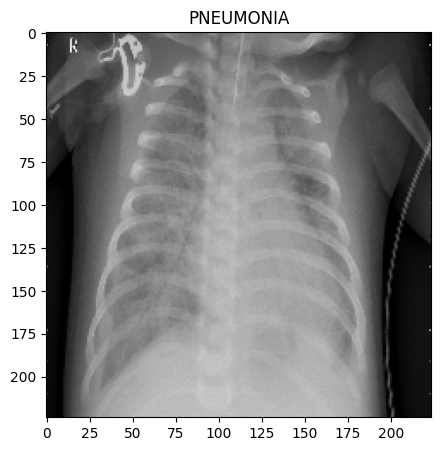

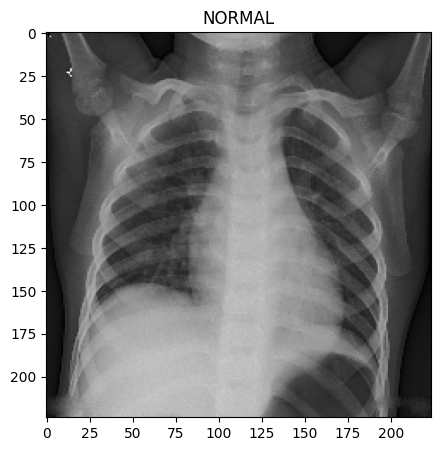

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

<Axes: xlabel='0', ylabel='count'>

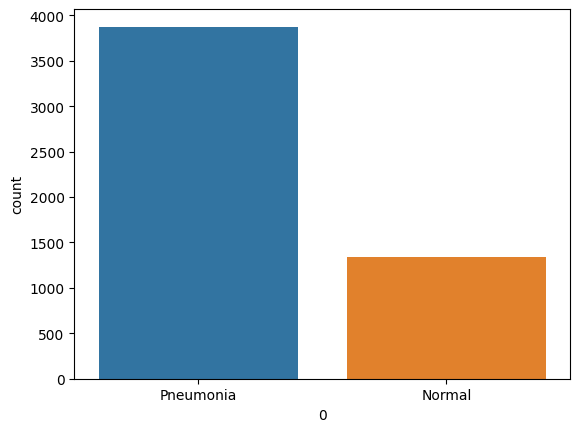

In [7]:
# Visualise class distribution

l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")

l = pd.DataFrame(l)
sns.countplot(x = 0, data = l)


This is clearly an issue because we have significantly more Pneumonia scans than Normal scans. The issue with class imbalance is that it can lead to biased model performance, as the model may become more inclined to predict the majority class, ignoring the minority class. This results in poor predictive accuracy and an underrepresentation of the minority class. 

### Split into features and labels

In [8]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [9]:
# create class weight dictionary

# Calculate class weights
total_samples = len(y_train)
class_samples_A = y_train.count(0)
class_samples_B = y_train.count(1)
class_weight_A = total_samples / (2 * class_samples_A)
class_weight_B = total_samples / (2 * class_samples_B)

class_weights_dict = {0: class_weight_A, 1: class_weight_B}

print(class_weights_dict)

{0: 0.6730322580645162, 1: 1.9448173005219984}


### Normalization 

In [10]:
#Normalization changes the values in the columns to a common scale.
#Pixel normalization technique is often used to speed up model learning.
#Dividing by 255 normalizes RGB values to be between 0 and 1.

x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

### Resize data for learning

In [11]:
#Numpy arrays are reshaped to prepare them to be fed into the model.

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

x_train.shape, x_val.shape, x_test.shape

In [12]:
x_train = np.repeat(x_train,3,-1)
x_test = np.repeat(x_test,3,-1)
x_val = np.repeat(x_val,3,-1)

x_train.shape, x_val.shape, x_test.shape

((5216, 224, 224, 3), (16, 224, 224, 3), (624, 224, 224, 3))

### Data Augmentation

In [13]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.2, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip = True,  # randomly flip images
    vertical_flip=False
    )

# rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True

datagen.fit(x_train)

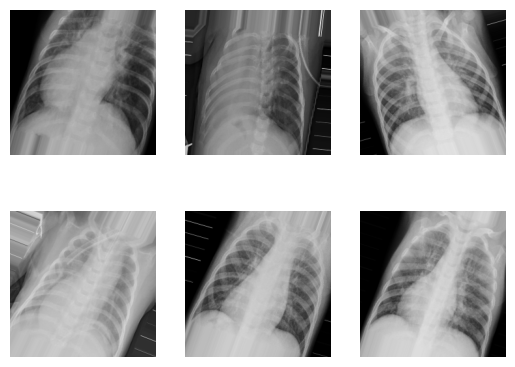

In [14]:
for X_batch, y_batch in datagen.flow(x_train,y_train, batch_size=6):
    for i in range(0, 6):
        plt.subplot(2,3,i+1)
        plt.imshow(X_batch[i])
        plt.axis('off')
    break

In [13]:
IMAGE_SHAPE = (img_size, img_size)

In [14]:
def plot_confusion_matrix(confusion_matrix, classes=["Pneumonia", "Normal"]):
    plt.figure(figsize=(8, 6))
    im = plt.imshow(confusion_matrix, interpolation='nearest', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Add color bar
    color_bar = plt.colorbar(im)
    color_bar.set_label('Score')

    # Set tick labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Rotate tick labels if needed
    plt.xticks(rotation=45, ha="right")

    # Add text annotations
    thresh = confusion_matrix.max() / 2
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

## Building the Model

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

#Construct the CNN model

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [19]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
history = model.fit(datagen.flow(x_train,y_train,batch_size=16), epochs = 12 , validation_data=datagen.flow(x_val,y_val), class_weight=class_weights_dict, callbacks=learning_rate_reduction)

Epoch 1/12
326/326 [==============================] - 360s 1s/step - loss: 0.3453 - accuracy: 0.8666 - val_loss: 11.1844 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
326/326 [==============================] - 343s 1s/step - loss: 0.2594 - accuracy: 0.8940 - val_loss: 7.0702 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
326/326 [==============================] - 348s 1s/step - loss: 0.2049 - accuracy: 0.9174 - val_loss: 3.1157 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/12
326/326 [==============================] - 343s 1s/step - loss: 0.2101 - accuracy: 0.9193 - val_loss: 0.9584 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/12
326/326 [==============================] - 332s 1s/step - loss: 0.1884 - accuracy: 0.9237 - val_loss: 1.3207 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/12
326/326 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9327
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 327s

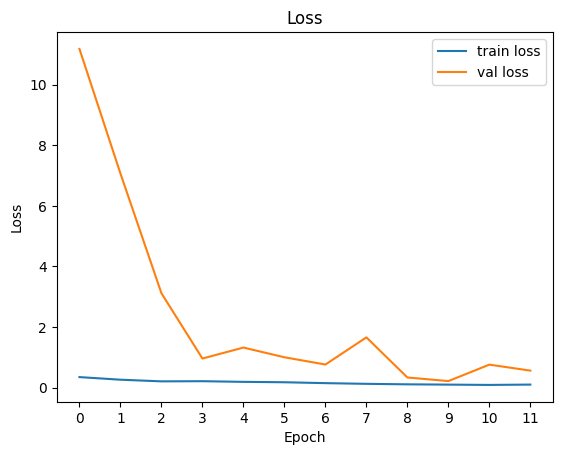

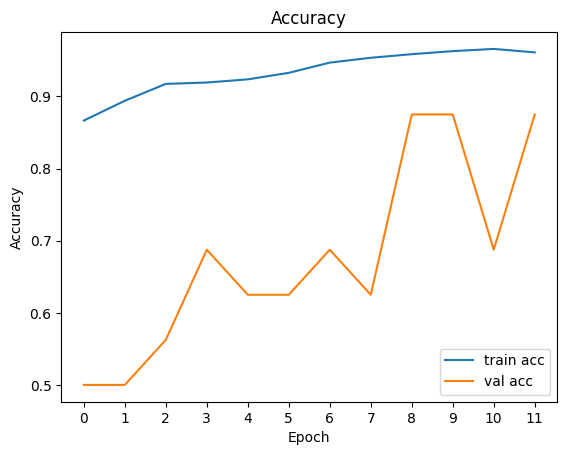

In [21]:
#plot training loss and validation loss

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(len(history.history['loss'])))
plt.legend()
plt.show()

#plot training accuracy and validation accuracy

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(history.history['accuracy'])))
plt.legend()
plt.show()

20/20 [==============================] - 8s 363ms/step - loss: 0.2925 - accuracy: 0.9215
Accuracy:  92.14743375778198 %
Loss:  0.2924772799015045


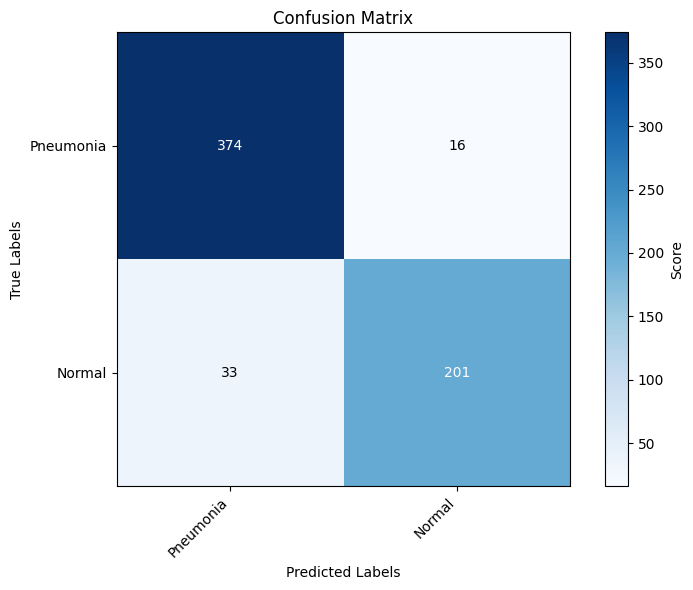

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.96      0.94       390
   Normal (Class 1)       0.93      0.86      0.89       234

           accuracy                           0.92       624
          macro avg       0.92      0.91      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [22]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

loss, acc = model.evaluate(x_test, y_test)
print("Accuracy: ", acc*100, "%")
print("Loss: ", loss)

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

In [24]:
model.save('custom_model.h5')